# Which authors tends to be more collaborative with external institutions?

In this script we will try to answer the question of which authors tends to be more collaborative with EUTOPIA institutions. 

## Brief overview

We see that the number of external collaborations almost coincides with the number of publications. We observe the collaboration rate, which is the proportion of external collaborations to the total number of publications.

In our Bayesian we set the *theta* paramater as the mean of the Beta distribution, which represents the central tendency of the collaboration rates. We define a collaborative author as one whose collaboration rate is higher than the mean collaboration rate. We also calculate the percentile of each author's collaboration rate based on the posterior samples. We also calculate the percentile of each author's collaboration rate based on the posterior samples. This percentile represents the author's relative position compared to other authors in terms of collaboration rates.

Results are saved to BigQuery table `FCT_AUTHOR_COLLABORATIVENESS`.



## Global imports & settings

In [1]:

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from box import Box
from google.cloud import bigquery
from scipy.stats import percentileofscore

In [11]:
# -------------------- GLOBAL VARIABLES --------------------
PATH_TO_CONFIG_FILE = '../config.yml'

# -------------------- LOAD CONFIGURATION --------------------
# Load the configuration file
config = Box.from_yaml(filename=PATH_TO_CONFIG_FILE)
# Initialize a BigQuery client
client = bigquery.Client(project=config.GCP.PROJECT_ID)
# Set the BigQuery dataset schema
schema = config.GCP.READ_SCHEMA
# Set the BigQuery write dataset schema
write_schema = config.GCP.ANALYTICS_SCHEMA
# Set numpy random seed
np.random.seed(config.RANDOM_SEED)

## Data preparation
After loading the general configuration, we will prepare the data from BigQuery:
1. Count the number of publications and external collaborations for each author. 
2. Calculate the proportion of external collaborations for each author.
3. Filter out authors from non-EUTOPIA institutions and authors with zero publications or zero collaborations.
4. Clip the collaboration rate to avoid issues with the Beta distribution in the Bayesian model.

In [3]:
# Read data via BigQuery
query = f"""
SELECT
  AUTHOR_SID,
  COUNT(ARTICLE_SID)                                                AS PUBLICATIONS,
  COUNT(DISTINCT IF(IS_EXTERNAL_COLLABORATION, ARTICLE_SID, NULL))  AS EXTERNAL_COLLABORATIONS
FROM
    {schema}.FCT_COLLABORATION
WHERE IS_ARTICLE_RELEVANT
GROUP BY AUTHOR_SID
"""
df = client.query(query).to_dataframe()

# We need to calculate the proportion of external collaborations for each author
df['COLLABORATION_RATE'] = df['EXTERNAL_COLLABORATIONS'] / df['PUBLICATIONS']

# Handle zero publications or zero collaborations to avoid issues with the Beta distribution
df = df[(df['PUBLICATIONS'] > 0) & (df['EXTERNAL_COLLABORATIONS'] >= 0)]
# Filter out outliers with extremely low number of publications
df = df[(df['PUBLICATIONS'] >= 10)]
# Clip the collaboration rate to avoid issues with the Beta distribution
df['COLLABORATION_RATE'] = np.clip(a=df['COLLABORATION_RATE'],
                                   a_min=1e-6,
                                   a_max=1 - 1e-6)

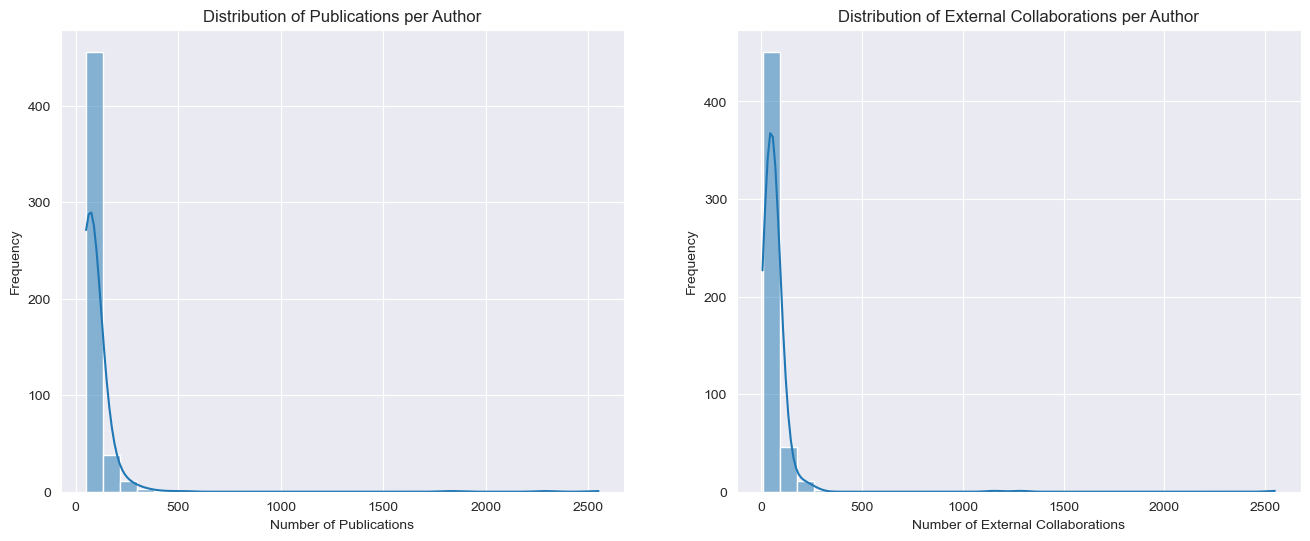

In [4]:
# Visualize the distributions of publications and external collaborations in side-by-side histograms
# 1. Distribution of Publications per Author
fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(df[df['PUBLICATIONS'] > 50]['PUBLICATIONS'], bins=30, kde=True, ax=plt1)
plt1.set_title('Distribution of Publications per Author')
plt1.set_xlabel('Number of Publications')
plt1.set_ylabel('Frequency')
# 2. Distribution of External Collaborations per Author
sns.histplot(df[df['PUBLICATIONS'] > 50]['EXTERNAL_COLLABORATIONS'], bins=30, kde=True, ax=plt2)
plt2.set_title('Distribution of External Collaborations per Author')
plt2.set_xlabel('Number of External Collaborations')
plt2.set_ylabel('Frequency')
plt.show()

## Bayesian model

We will define a simple Bayesian model to describe the collaboration rate of authors with EUTOPIA institutions. Using Bayesian inference, we estimate the parameters (`alpha` and `beta`) of a Beta distribution that best describe the observed collaboration rates of authors.

**Prior:** We use HalfNormal priors for the parameters `alpha` and `beta`. The HalfNormal distribution is a suitable choice for positive real-valued parameters because it only allows positive values. We set the standard deviation of the HalfNormal priors to 10, which is a relatively uninformative prior and hence not too constraining.

**Data likelihood:** We model the observed collaboration rates as a Beta distribution with parameters `alpha` and `beta`. Beta distribution is a suitable choice for modeling the collaboration rate because it is a continuous distribution that is constrained between 0 and 1. The parameters `alpha` and `beta` of the Beta distribution are positive real numbers that control the shape of the distribution. 

In [5]:
# Define the Bayesian model using PyMC
with pm.Model() as model:
    # Priors influenced by the number of publications
    alpha = pm.HalfNormal(name='alpha',
                          sigma=10)
    beta = pm.HalfNormal(name='beta',
                         sigma=10)

    # Deterministic variable for mean collaboration rate
    theta = pm.Deterministic(name='theta',
                             var=alpha / (alpha + beta))

    # Likelihood (sampling distribution) of observations
    y_obs = pm.Beta(name='y_obs',
                    alpha=alpha,
                    beta=beta,
                    observed=df['COLLABORATION_RATE'])

    # Inference
    trace = pm.sample(draws=2000,
                      tune=1000,
                      cores=4,
                      target_accept=0.95,
                      return_inferencedata=True,
                      progressbar=True,
                      random_seed=config.RANDOM_SEED)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 34 seconds.


## Analysis: author collaborativeness with external institutions

The expected value of the Beta distribution is given by `alpha / (alpha + beta)`, which represents the central tendency of the collaboration rates. 
Then from the posterior distributions of `alpha` and `beta`, we can calculate the expected value of the collaboration rate, `theta`. This expected value represents the central tendency of the collaboration rates across all authors. 
We compare individual authors' collaboration rates to the inferred mean collaboration rate (`theta_mean`). Authors with collaboration rates higher than this mean are considered to be **more collaborative with external institutions**.

Lastly, we calculate the percentile of each author's collaboration rate based on the posterior samples. This percentile represents the **author's relative position** compared to other authors in terms of collaboration rates.

### Analyze sampling traces and posterior distributions

        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha  0.826  0.013     0.801      0.851        0.0      0.0    3732.0   
beta   0.239  0.003     0.234      0.244        0.0      0.0    3797.0   
theta  0.776  0.003     0.771      0.781        0.0      0.0    5510.0   

       ess_tail  r_hat  
alpha    4547.0    1.0  
beta     4612.0    1.0  
theta    5250.0    1.0  


array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>,
       <Axes: title={'center': 'theta'}>], dtype=object)

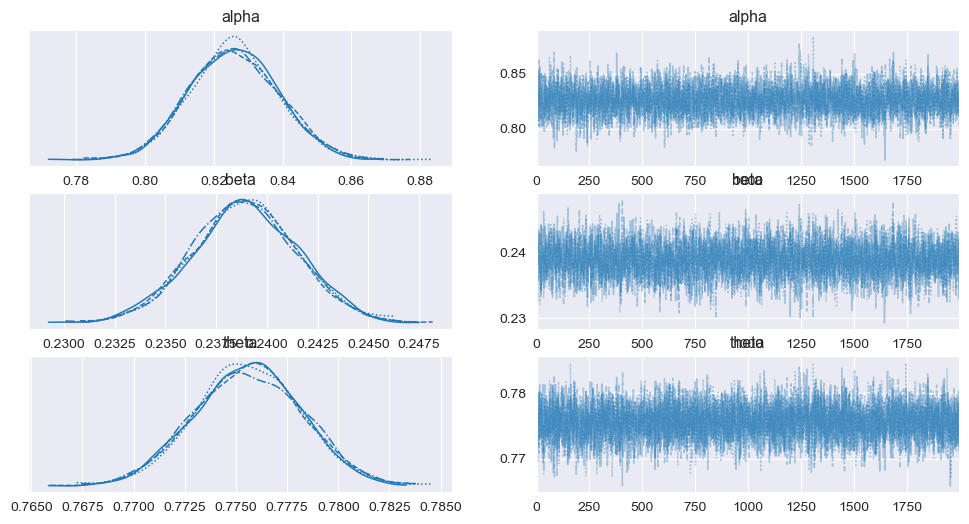

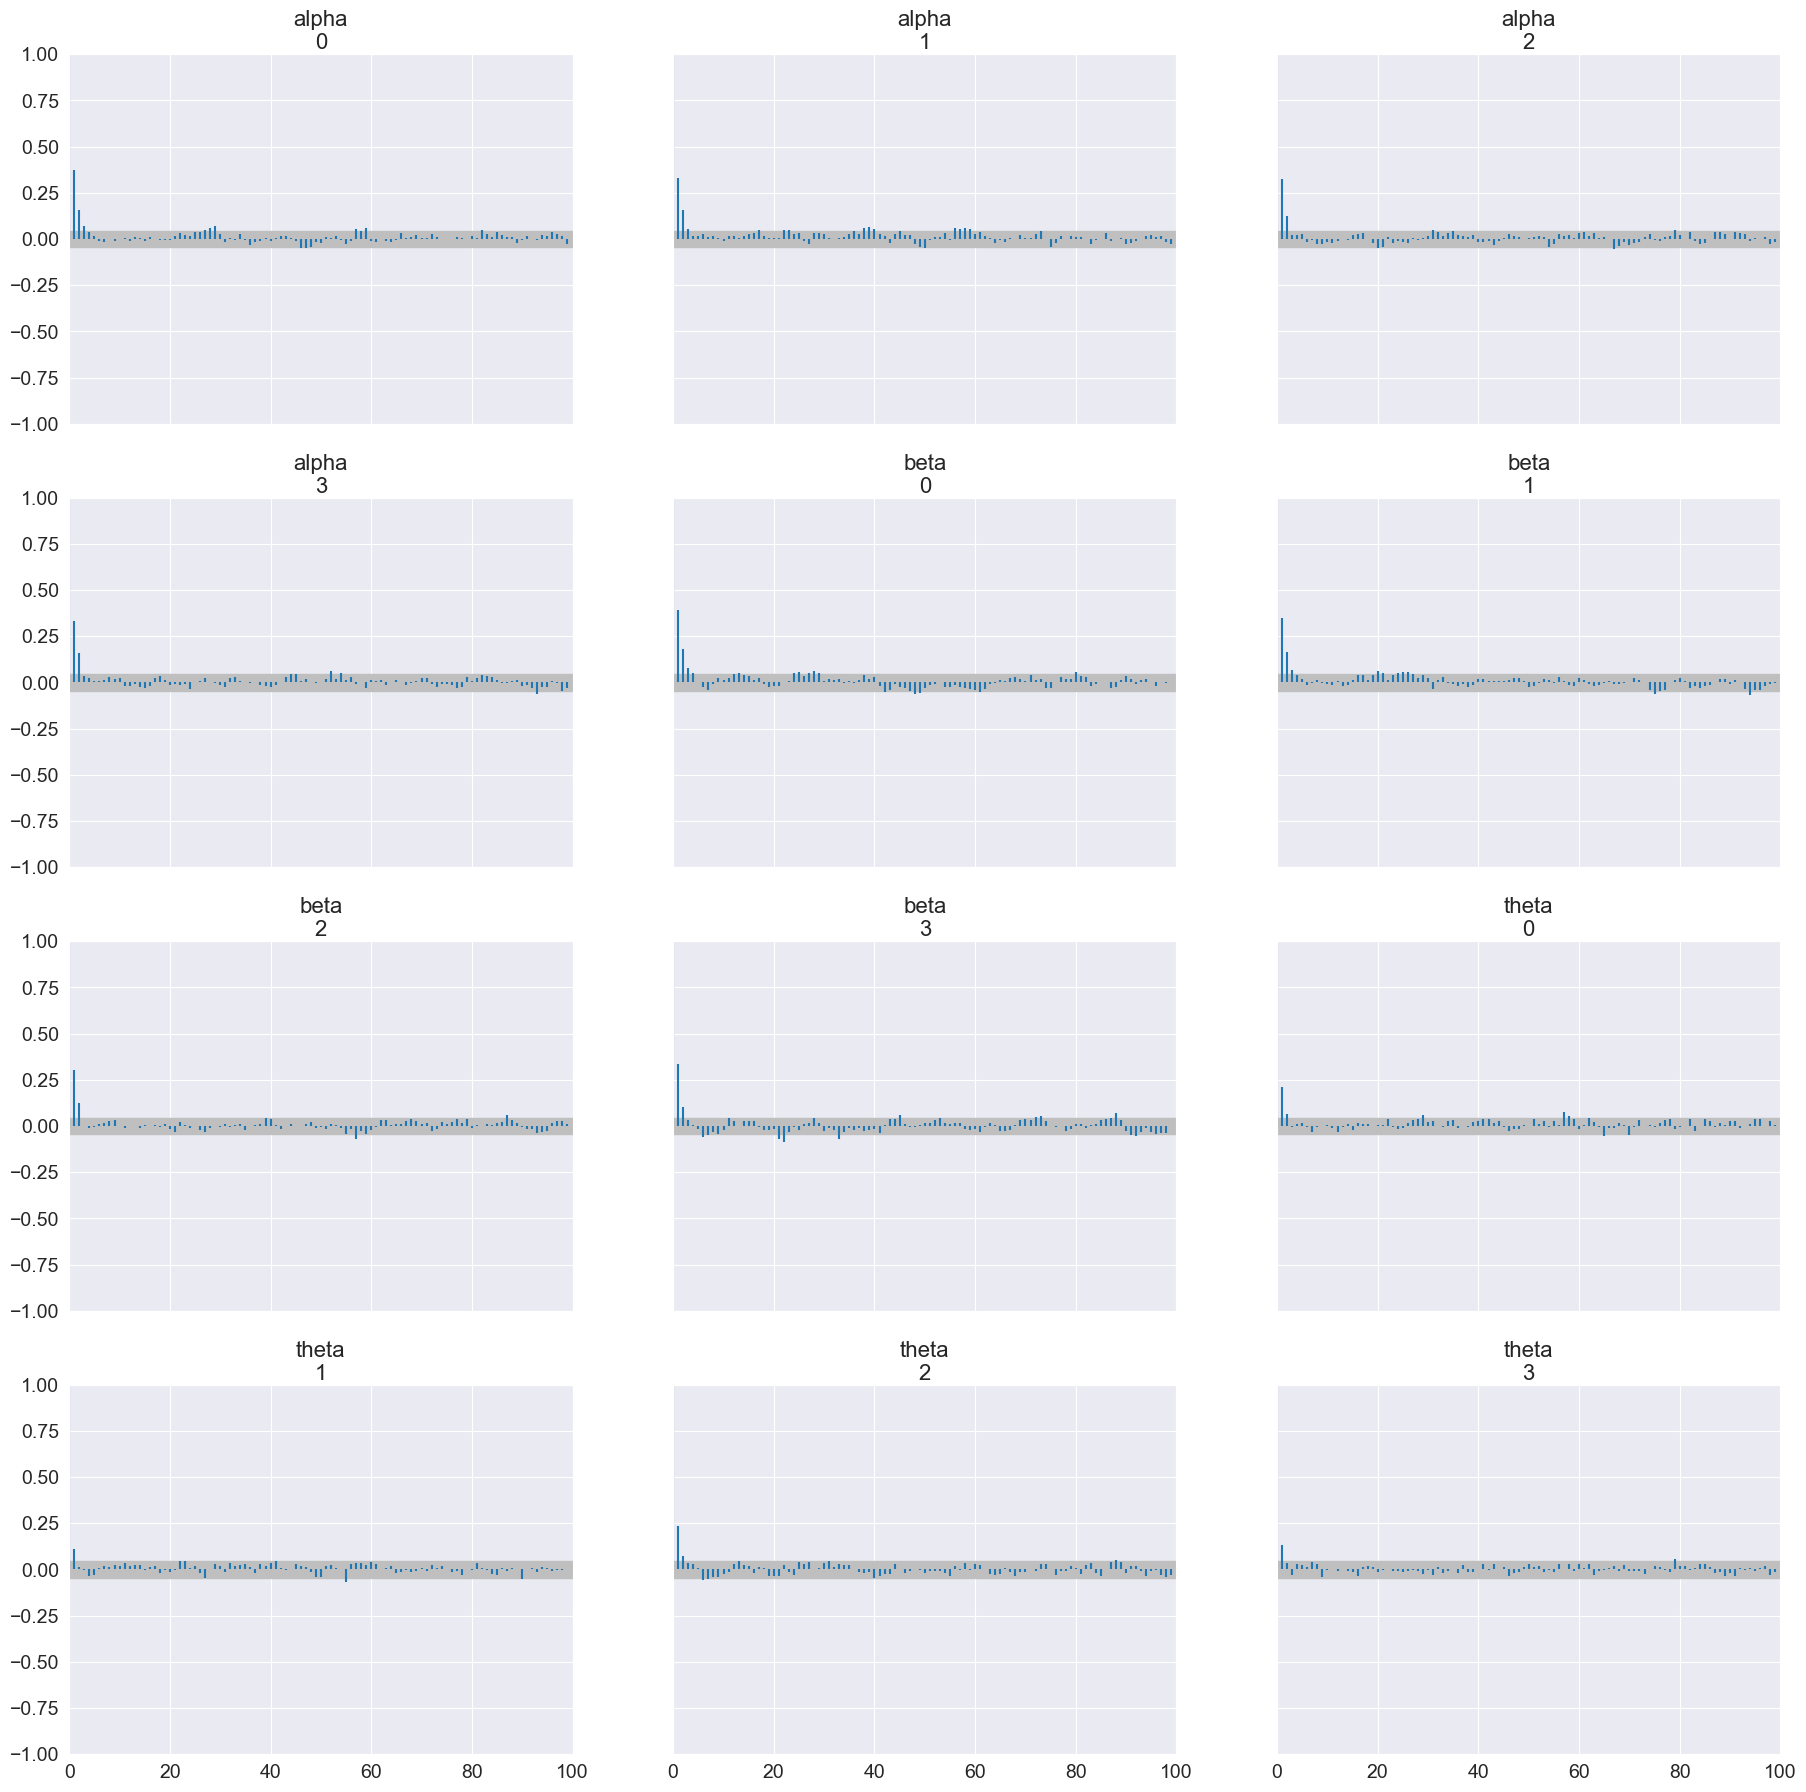

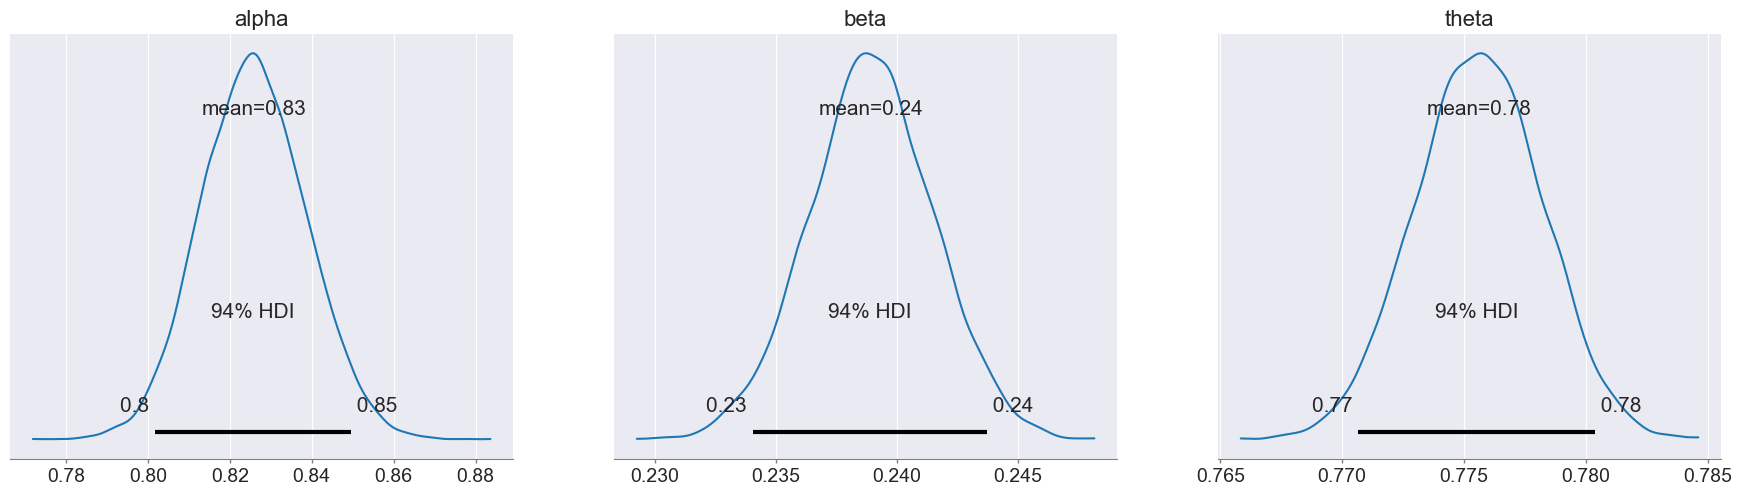

In [6]:
# Summarize the trace
summary = az.summary(trace, hdi_prob=0.95)
print(summary)

# Visualize the trace and posterior distributions
az.plot_trace(trace)
az.plot_autocorr(trace)
az.plot_posterior(trace)

In [7]:
# Extract the mean collaboration rate from the posterior distribution 
theta_mean = summary.loc['theta', 'mean']

# Sample collaboration rates from the posterior distribution
posterior_samples = trace.posterior.stack(samples=("chain", "draw"))
alpha_samples = posterior_samples['alpha'].values
beta_samples = posterior_samples['beta'].values

# Calculate the collaboration rate percentiles for each author
collaboration_rate_samples = np.random.beta(alpha_samples, beta_samples)
collaboration_rate_samples_sorted = np.sort(collaboration_rate_samples, axis=0)
percentiles = np.array([percentileofscore(collaboration_rate_samples_sorted, x) for x in df['COLLABORATION_RATE']])
df['COLLABORATION_RATE_PERCENTILE'] = percentiles

# Get more collaborative authors
df['IS_AUTHOR_MORE_COLLABORATIVE'] = df['COLLABORATION_RATE'] > theta_mean

In [8]:
# Query the author full names from DIM_AUTHOR table from BigQuery
query = f"""
SELECT
    A.AUTHOR_SID,
    A.AUTHOR_FULL_NAME,
    STRING_AGG(DISTINCT F.INSTITUTION_SID) AS INSTITUTIONS
FROM
    {schema}.FCT_COLLABORATION F
INNER JOIN 
    {schema}.DIM_AUTHOR A USING(AUTHOR_SID)
WHERE F.IS_ARTICLE_RELEVANT
GROUP BY A.AUTHOR_SID, A.AUTHOR_FULL_NAME
"""
# Query the author full names
df_author = client.query(query).to_dataframe()

# Merge the top authors with their full names
authors = df.merge(df_author, on='AUTHOR_SID')
pd.set_option('display.max_rows', None)
# Only show authors working on institution UNI_LJ
authors[authors['INSTITUTIONS'].str.contains('UNI_LJ')].sort_values(by='COLLABORATION_RATE_PERCENTILE',
                                                                    ascending=False).head(100)

,AUTHOR_SID,PUBLICATIONS,EXTERNAL_COLLABORATIONS,COLLABORATION_RATE,COLLABORATION_RATE_PERCENTILE,IS_AUTHOR_MORE_COLLABORATIVE,AUTHOR_FULL_NAME,INSTITUTIONS
6616,e0a8410c22f0bc3583c538db5ae5ec87,15,15,0.999999,96.4375,True,Boštjan Genorio,UNI_LJ
7421,559b8b2c410bd001b221c5208de2b8b1,12,12,0.999999,96.4375,True,Dušan D. Repovš,UNI_LJ
8193,38e5e08ad7d6b016a4925000f3060ac8,14,14,0.999999,96.4375,True,Miha Krofel,UNI_LJ
6733,fde6bc5b2d35cfc20c0dff7fc6d29d59,11,11,0.999999,96.4375,True,Robert Zorec,UNI_LJ
2854,ae511fe7d6e6c51f9c70afe1c8474525,18,18,0.999999,96.4375,True,Cene Fišer,UNI_LJ
8022,e40fd30336b933e33d025af2c7602584,10,10,0.999999,96.4375,True,Jernej Jakše,UNI_LJ
2807,1ea25a3de606684ab46e7f0f67ba43e2,17,17,0.999999,96.4375,True,Klemen Dovc,UNI_LJ
7936,a31e9e0c8b3dd1424793c929d4a19921,11,11,0.999999,96.4375,True,Katarina Čufar,UNI_LJ
7852,7f223fcef7c4c49ccf719d50f660b727,11,11,0.999999,96.4375,True,Anja Oštrbenk,UNI_LJ
4229,0089fb0d2d104a85df920bba051e15e3,10,10,0.999999,96.4375,True,Matej Černe,UNI_LJ


### Save the results to BigQuery table: FCT_AUTHOR_COLLABORATIVENESS

In [9]:
df.head(5)

,AUTHOR_SID,PUBLICATIONS,EXTERNAL_COLLABORATIONS,COLLABORATION_RATE,COLLABORATION_RATE_PERCENTILE,IS_AUTHOR_MORE_COLLABORATIVE
0,e97388724698d1c0d50448cebd59e81c,27,16,0.592593,23.2250,False
1,dae26ddaeeeb06d735afac6eaa9969dc,29,19,0.655172,26.4500,False
2,219f86b1ffef07d67643828493d32eae,44,24,0.545455,21.0625,False
3,e0cae8ba06f06d5c23f055405edd7bb9,25,20,0.8,35.9875,True
4,fd72a8e76bec84c6a53da8a966d204cd,11,11,0.999999,96.4375,True


In [12]:
# Save the results to BigQuery
table_id = f"{write_schema}.AUTHOR_COLLABORATIVENESS"
job_config = bigquery.LoadJobConfig(
    write_disposition="WRITE_TRUNCATE",
)

job = client.load_table_from_dataframe(df, table_id, job_config=job_config)